<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/42_hier_gaussian.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(hier_gaussian_model)=
# Modello gerarchico gaussiano

In questo capitolo, proseguiremo la discussione sul modello gerarchico bayesiano utilizzando PyMC, concentrandoci questa volta sul caso in cui i dati seguono una distribuzione gaussiana.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

## Preparazione del notebook


Per discutere il modello gerarchico gaussiano, utilizzeremo i dati forniti da un [tutorial](https://www.pymc.io/projects/examples/en/latest/howto/data_container.html) presente sul sito del pacchetto PyMC. In questo esempio viene utilizzato un set di dati artificiale relativo alle temperature in 3 città nel corso di 2 mesi.

In [3]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2023-05-01", end="2023-07-01")

for city, mu in {"Berlin": 15, "San Marino": 20, "Paris": 17}.items():
    df_data[city] = rng.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

,Berlin,San Marino,Paris
date,,,
2023-05-01,15.304717,20.162753,17.835111
2023-05-02,13.960016,20.586222,17.356871
2023-05-03,15.750451,20.711227,18.463303
2023-05-04,15.940565,20.793347,15.811237
2023-05-05,13.048965,19.651275,16.360248


Possiamo visuaizzare i valori della temperatura per ciascuna città mediante un istogramma.

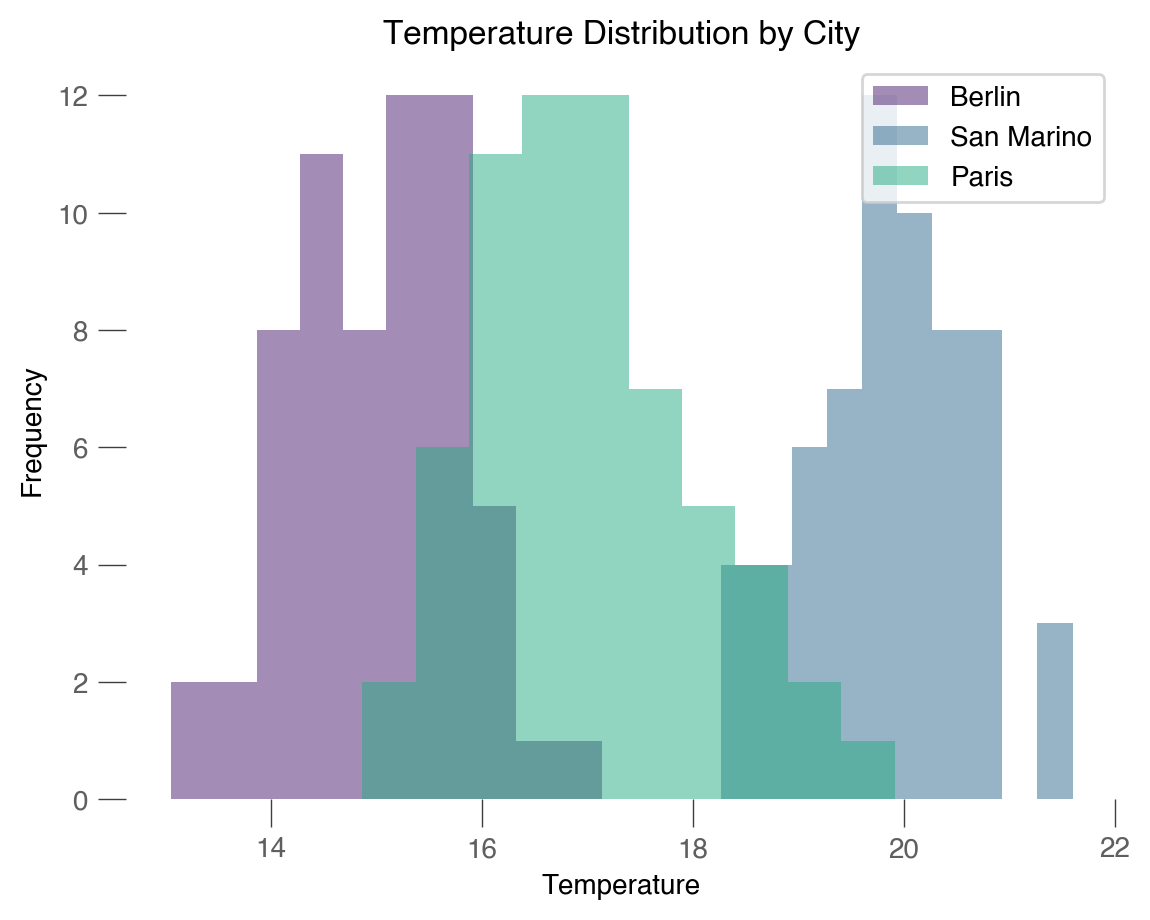

In [4]:
for column in df_data.columns:
    plt.hist(df_data[column], alpha=0.5, label=column)
plt.title('Temperature Distribution by City')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

Usiamo il contenitore `ConstantData` per assegnare etichette nominate alle dimensioni dei dati. Questo si realizza passando un dizionario di coppie chiave-valore 'dimensione: coordinata' all'argomento `coords` di `pm.Model` durante la creazione del modello. Nel caso presente definiamo due coordinate:

In [5]:
# The data has two dimensions: date and city
# The "coordinates" are the unique values that these dimensions can take
coords = {"date": df_data.index, "city": df_data.columns}
display(coords)

{'date': DatetimeIndex(['2023-05-01', '2023-05-02', '2023-05-03', '2023-05-04',
                '2023-05-05', '2023-05-06', '2023-05-07', '2023-05-08',
                '2023-05-09', '2023-05-10', '2023-05-11', '2023-05-12',
                '2023-05-13', '2023-05-14', '2023-05-15', '2023-05-16',
                '2023-05-17', '2023-05-18', '2023-05-19', '2023-05-20',
                '2023-05-21', '2023-05-22', '2023-05-23', '2023-05-24',
                '2023-05-25', '2023-05-26', '2023-05-27', '2023-05-28',
                '2023-05-29', '2023-05-30', '2023-05-31', '2023-06-01',
                '2023-06-02', '2023-06-03', '2023-06-04', '2023-06-05',
                '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09',
                '2023-06-10', '2023-06-11', '2023-06-12', '2023-06-13',
                '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-17',
                '2023-06-18', '2023-06-19', '2023-06-20', '2023-06-21',
                '2023-06-22', '2023-06-23', '2023-06-24'

Formuliamo ora un modello gerarchico che assume una temperatura media per il continente europeo e modella ogni città in relazione a questa media continentale. Il modello PyMC ha la forma seguente.

In [6]:
with pm.Model(coords=coords) as model:
    data = pm.ConstantData("observed_temp", df_data, dims=("date", "city"))

    europe_mean = pm.Normal("europe_mean_temp", mu=17.0, sigma=3.0)
    city_offset = pm.Normal("city_offset", mu=0.0, sigma=3.0, dims="city")
    city_temperature = pm.Deterministic(
        "expected_city_temp", europe_mean + city_offset, dims="city"
    )

    sigma = pm.Exponential("sigma", 1)
    pm.Normal(
        "temperature",
        mu=city_temperature,
        sigma=sigma,
        observed=data,
        dims=("date", "city"),
    )

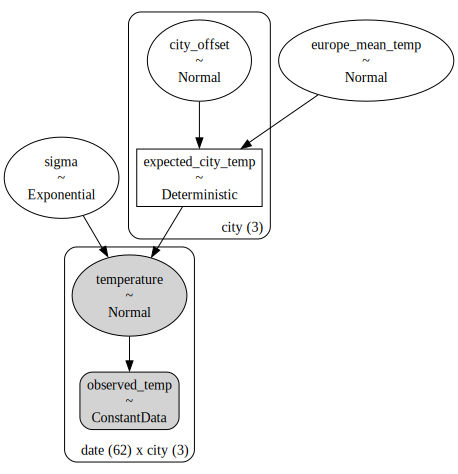

In [7]:
pm.model_to_graphviz(model)

Eseguiamo il campionamento.

In [8]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:02.352686
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 0:  35%|███▌      | 700/2000 [00:03<00:00, 6529.42it/s]


Running chain 0:  70%|███████   | 1400/2000 [00:03<00:00, 6603.25it/s]



Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 502.61it/s] 


Sampling time =  0:00:04.363863
Transforming variables...
Transformation time =  0:00:00.078400
Computing Log Likelihood...
Log Likelihood time =  0:00:00.400957


Esaminiamo le distribuzioni a posteriori dei parametri del modello.

In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
europe_mean_temp,17.272,1.462,14.572,20.012,0.062,0.044,555.0,821.0,1.01
city_offset[Berlin],-2.239,1.465,-4.891,0.554,0.062,0.044,562.0,869.0,1.01
city_offset[San Marino],2.591,1.464,-0.072,5.377,0.061,0.046,566.0,824.0,1.01
city_offset[Paris],-0.266,1.466,-2.891,2.509,0.062,0.044,552.0,772.0,1.01
sigma,0.879,0.046,0.797,0.967,0.001,0.001,1166.0,1238.0,1.01
expected_city_temp[Berlin],15.033,0.110,14.824,15.239,0.002,0.001,4207.0,3200.0,1.00
expected_city_temp[San Marino],19.862,0.111,19.662,20.086,0.002,0.001,4320.0,2755.0,1.00
expected_city_temp[Paris],17.006,0.107,16.818,17.216,0.002,0.001,4205.0,3180.0,1.00


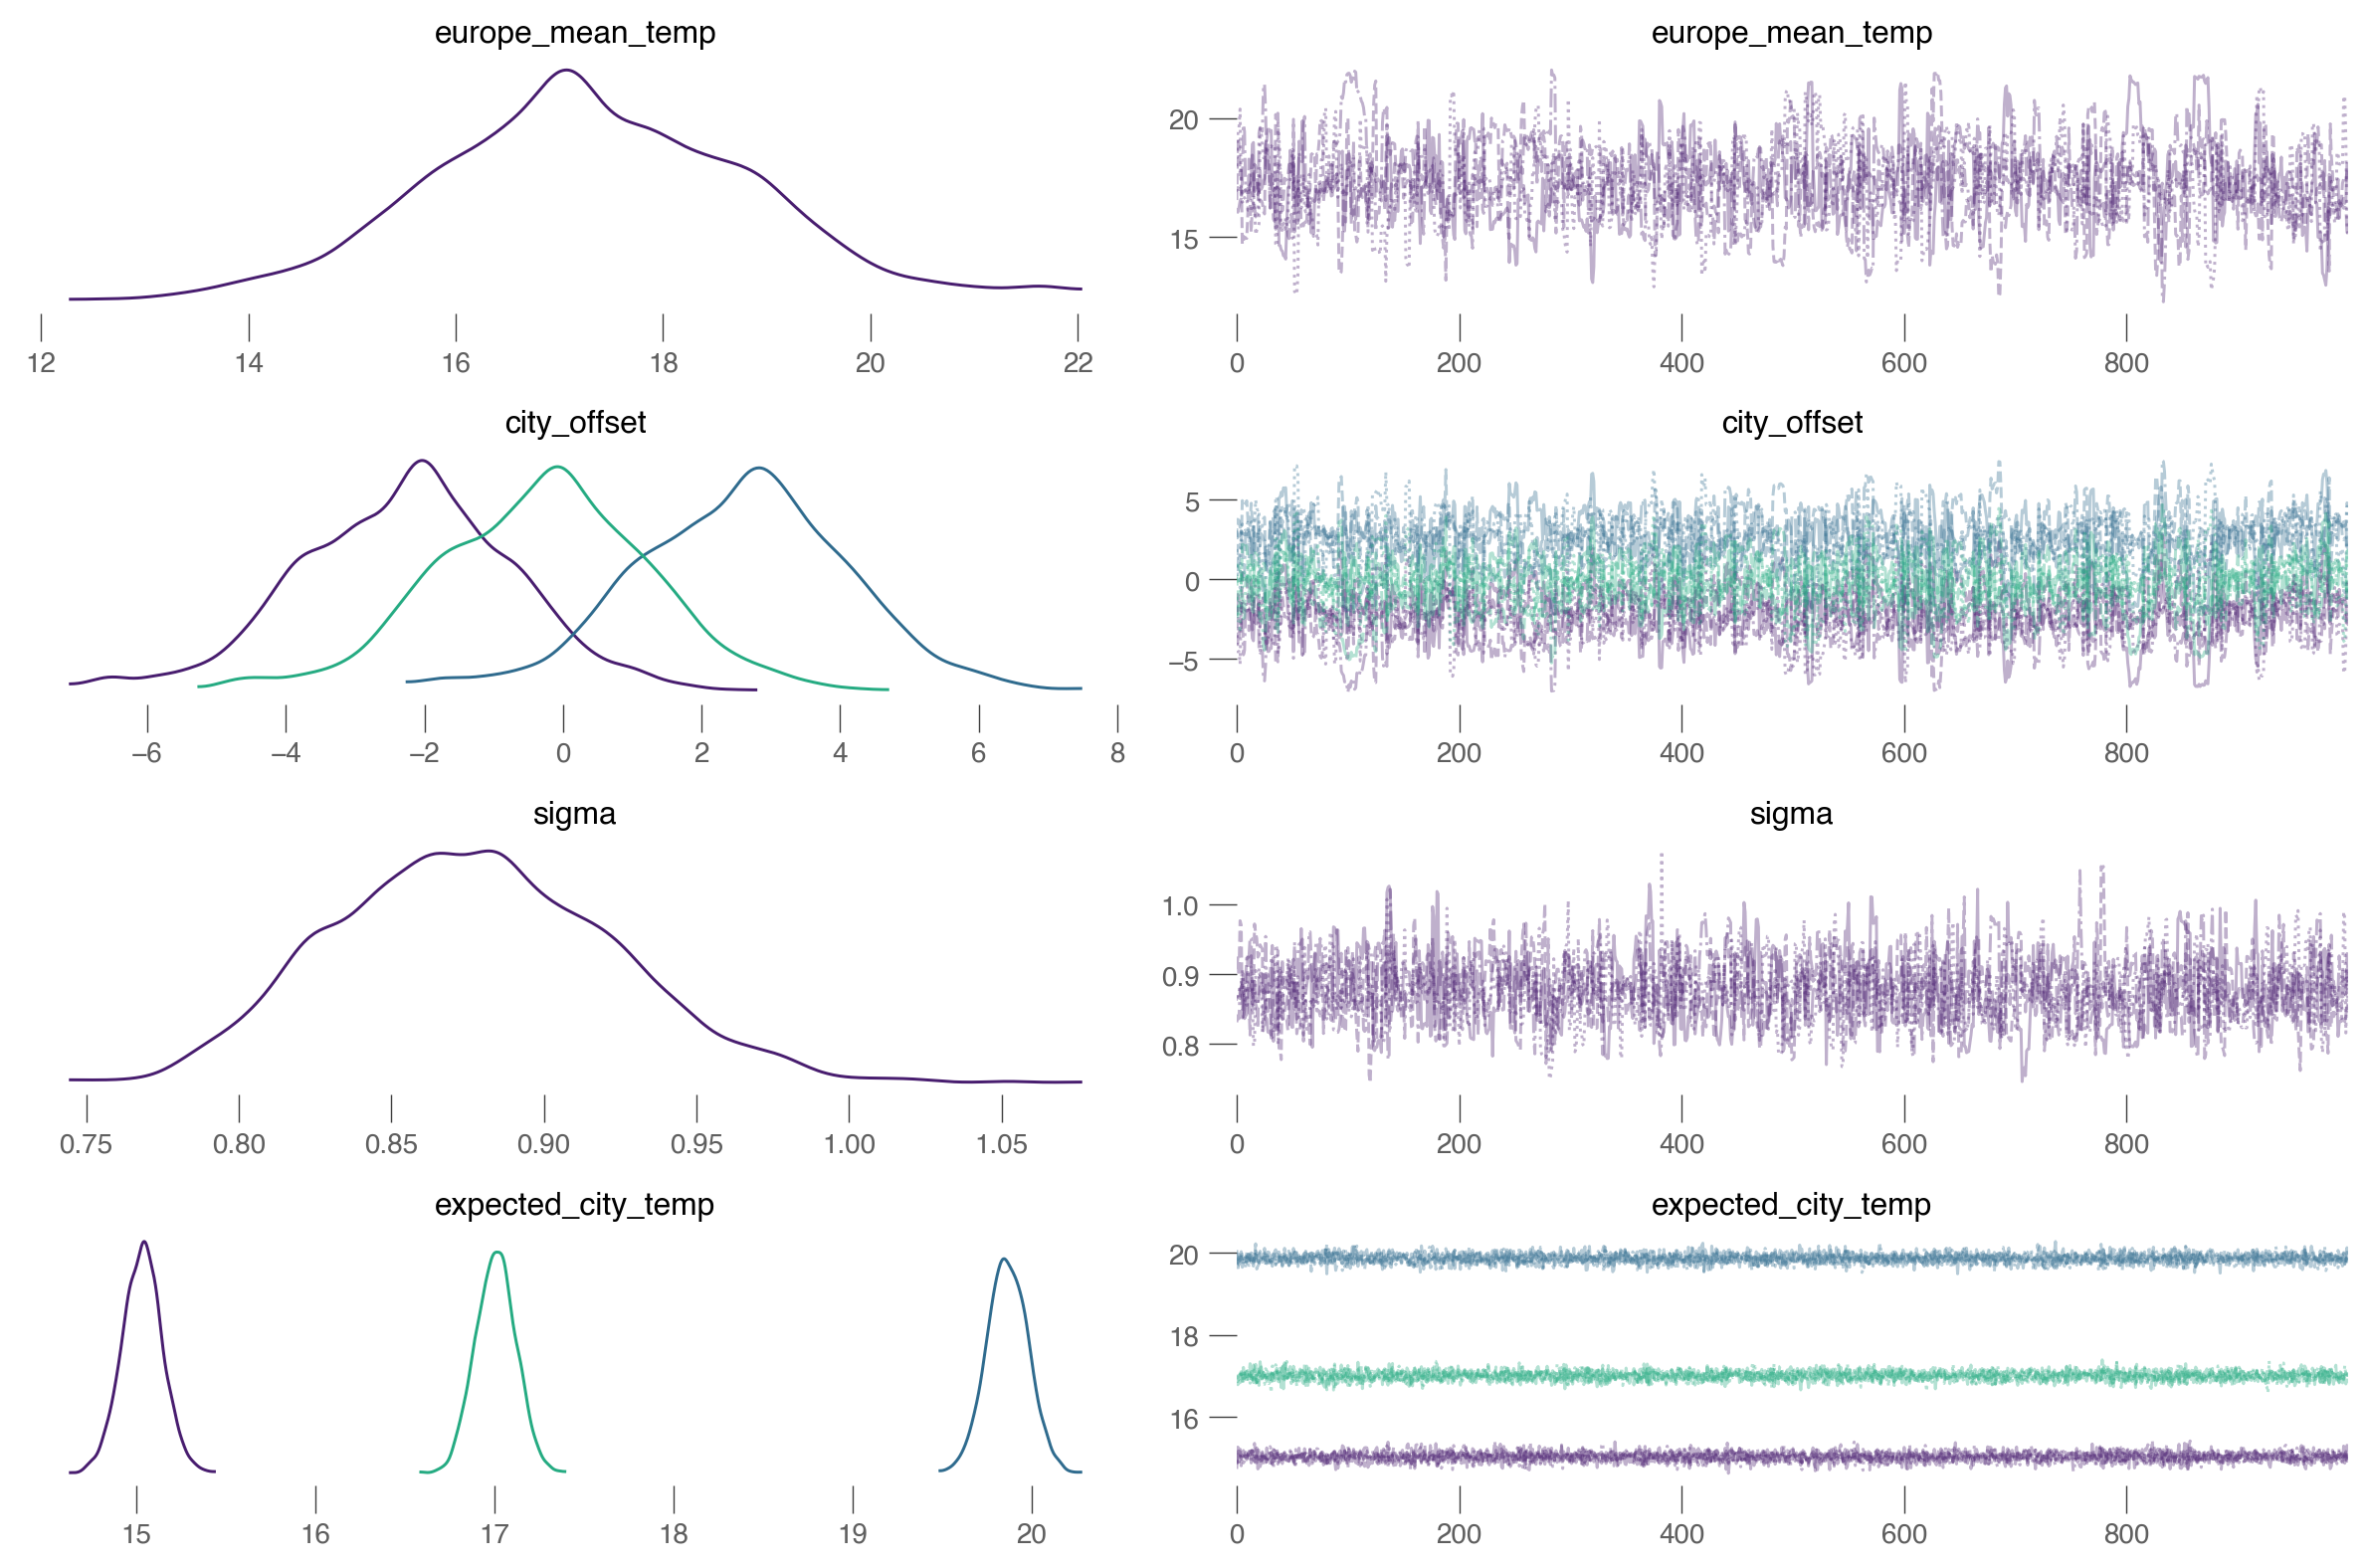

In [9]:
az.plot_trace(idata, combined=True)
plt.tight_layout()
plt.show()

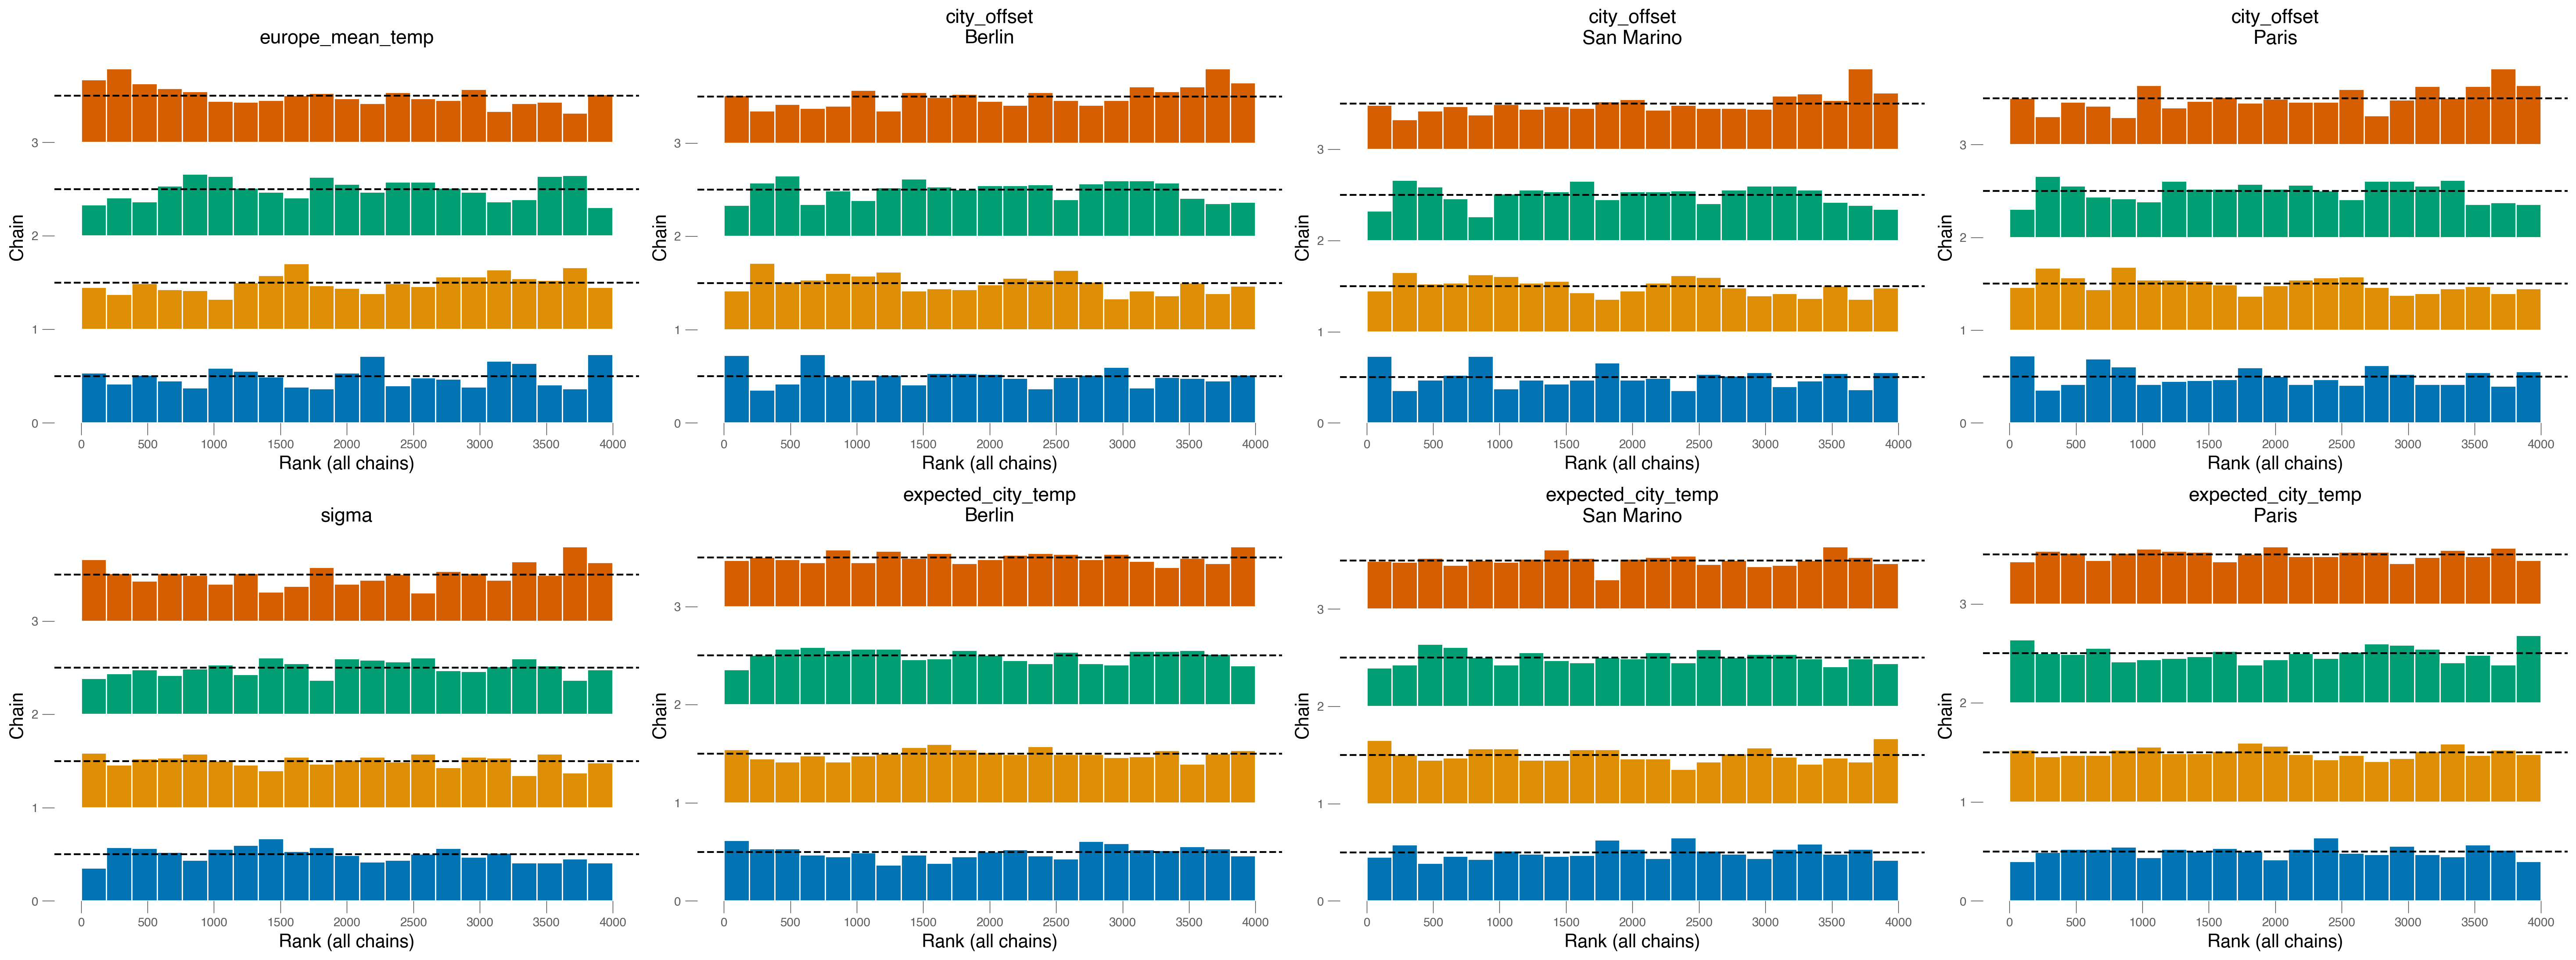

In [13]:
az.plot_rank(idata)
plt.tight_layout()
plt.show()

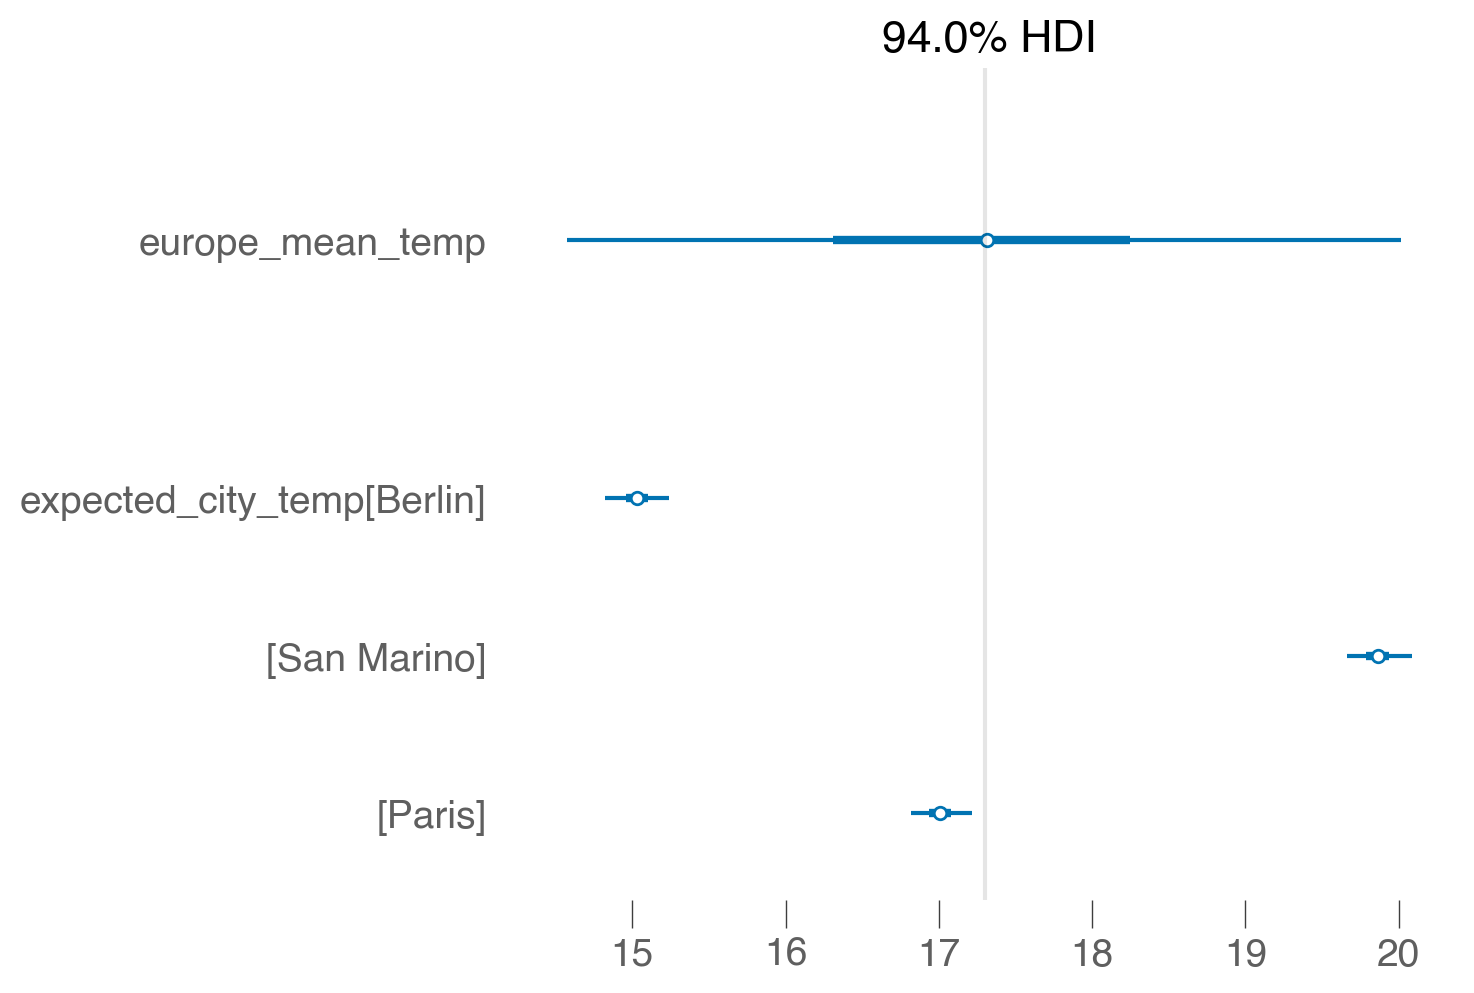

In [14]:
var_names=["europe_mean_temp", "expected_city_temp"]
az.plot_forest(idata, var_names=var_names, combined=True)
obs_mean=model["observed_temp"].eval().mean()
plt.axvline(x = obs_mean, color = 'black', alpha=0.1)
plt.show()

Valutiamo il modello mediante un controllo predittivo a posteriori (Posterior Predictive Check, PPC). Questa tecnica prevede la generazione di dati simulati dal modello, utilizzando i parametri estratti dalle distribuzioni a posteriori, per poi confrontare queste simulazioni con i dati osservati. Questo processo permette di verificare quanto accuratamente il modello riesca a riprodurre le caratteristiche dei dati e, di conseguenza, la sua adeguatezza.

In [15]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [temperature]


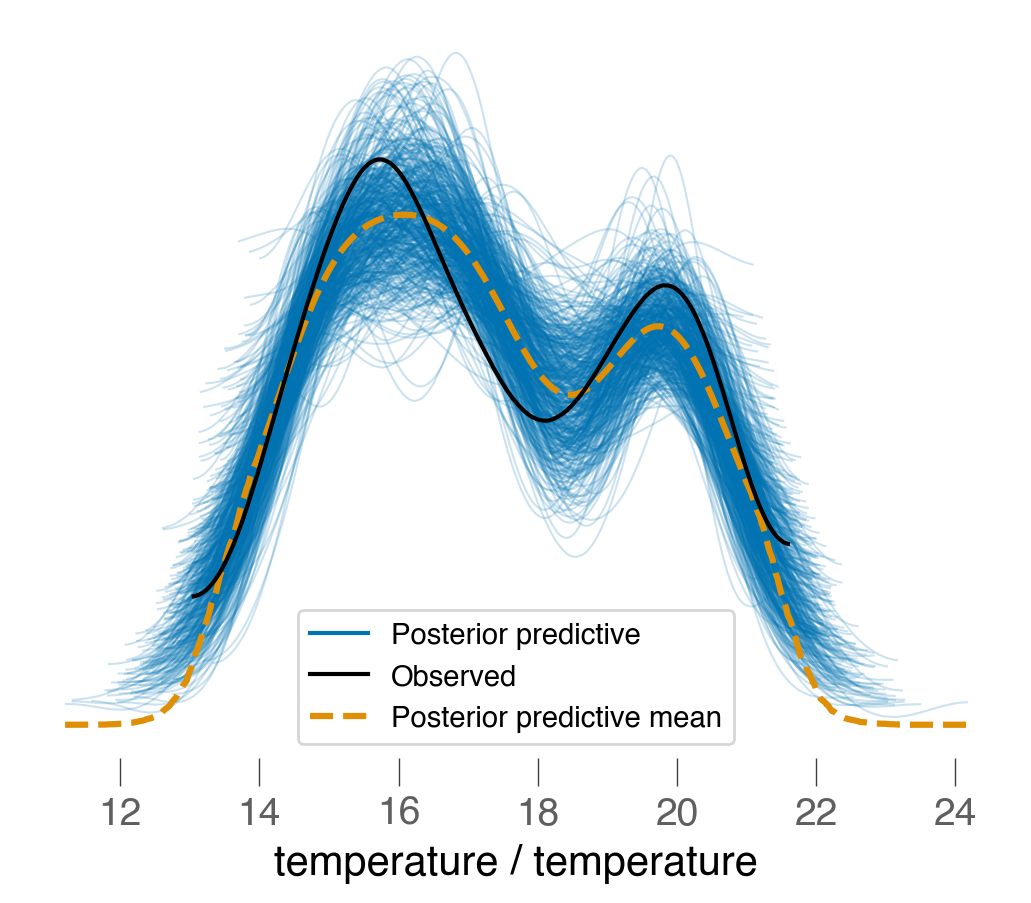

In [16]:
az.plot_ppc(post_pred, num_pp_samples=500)
plt.show()

L'adattamento del modello ai dati è molto buono.

Calcoliamo ora la Expected Log Predictive Density (ELPD) e la diagnostica Pareto $k$.

In [17]:
m_loo = az.loo(idata)
m_loo

Computed from 4000 posterior samples and 186 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -241.25     9.86
p_loo        3.83        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      186  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

La metrica diagnostica Pareto $k$ non indica la presenza di valori anomali o outlier nel set di dati.

## Watermark

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Aug 30 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

pytensor: 2.14.2

bambi     : 0.12.0
numpy     : 1.25.2
matplotlib: 3.7.2
pandas    : 2.0.3
seaborn   : 0.12.2
scipy     : 1.11.2
arviz     : 0.16.1
pymc      : 5.7.2

Watermark: 2.4.3

